In [2]:
import os
import ipynb
import warnings
from IPython.utils import io

from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 

import numpy as np
import pandas as pd
import seaborn as sns

import statistics
from scipy.stats import loguniform

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils._testing import ignore_warnings 
from sklearn.metrics import classification_report

from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb
from ipynb.fs.full.accuracy_plots import cumulative_accuracy_plot #import fx from accuracy_plots.ipynb
from ipynb.fs.full.accuracy_plots import accuracy_by_nfeatures #import fx from accuracy_plots.ipynb

In [4]:
#Restore saved class instances & dataframes from 00_EDA.ipynb
%store -r prep_dwt_8 prep_wang_8 prep_jones_8

%store -r dwt_8 wang_8 jones_8
dwt_8 = dwt_8
wang_8 = wang_8
jones_8 = jones_8

%store -r dwt_topten_8 wang_topten_8 jones_topten_8
dwt_topten_8 = dwt_topten_8
wang_topten_8 = wang_topten_8
jones_topten_8 = jones_topten_8

%store -r dwt_4 wang_4 jones_4
dwt_4 = dwt_4
wang_4 = wang_4
jones_4 = jones_4

%store -r dwt_topten_4 wang_topten_4 jones_topten_4
dwt_topten_4 = dwt_topten_4
wang_topten_4 = wang_topten_4
jones_topten_4 = jones_topten_4


## Logistic Regression

In [1]:
def log_reg_default(df, n_iter=1000, balanced=False):

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],
    }

    for i in range(n_iter): 

        if(balanced == False):

            subset_0 = df[df['state'] == 0]
            subset_1 = df[df['state'] == 1]

            subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
            df = pd.concat([subset_0, subset_1])
                     
        x = df.loc[:, df.columns != 'state'] #features
        y = df.loc[:, df.columns == 'state'] #supervisor

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()    
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        log_reg_model = LogisticRegression() 
        log_reg_model.fit(x_train, y_train.values.ravel())
        
        y_pred = log_reg_model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = log_reg_model.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [5]:
lr_default_acc_dwt_8 = log_reg_default(dwt_8, n_iter=10000)
lr_default_acc_wang_8 = log_reg_default(wang_8, n_iter=10000)
lr_default_acc_jones_8 = log_reg_default(jones_8, n_iter=10000)

print('DWT Method Accuracy ', round(lr_default_acc_dwt_8['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(lr_default_acc_wang_8['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(lr_default_acc_jones_8['accuracy'].mean(), 4))

DWT Method Accuracy  0.9414
Wang Method Accuracy  0.9444
Jones Method Accuracy  0.8881


## Accuracy by files and n Fisher's features

### Logistic Regression: Default Parameters

In [7]:
lr_default_acc_metrics_dwt = accuracy_by_nfeatures(
                    class_instance=prep_dwt_8, file_name='DWT', classifier=log_reg_default, n_features=29, n_iter=1000)
lr_default_acc_metrics_wang = accuracy_by_nfeatures(
                    class_instance=prep_wang_8, file_name='Wang', classifier=log_reg_default, n_features=29, n_iter=1000)
lr_default_acc_metrics_jones = accuracy_by_nfeatures(
                    class_instance=prep_jones_8, file_name='Jones', classifier=log_reg_default, n_features=29, n_iter=1000)

In [8]:
lr_default_acc_metrics_dwt = lr_default_acc_metrics_dwt.rename(
                                columns = lambda col: f"{col}_dwt" 
                                if col not in ('n_features', 'file_name') else col)

lr_default_acc_metrics_wang = lr_default_acc_metrics_wang.rename(
                                columns = lambda col: f"{col}_wang" 
                                if col not in ('n_features', 'file_name') else col)

lr_default_acc_metrics_jones = lr_default_acc_metrics_jones.rename(
                                columns = lambda col: f"{col}_jones" 
                                if col not in ('n_features', 'file_name') else col)     

In [9]:
#merge three dataframes on n_features
merged_logreg_default = lr_default_acc_metrics_dwt.merge(lr_default_acc_metrics_wang, how='right', on='n_features').merge(lr_default_acc_metrics_jones, how='right', on='n_features')
merged_logreg_default.head()

%store merged_logreg_default

Stored 'merged_logreg_default' (DataFrame)


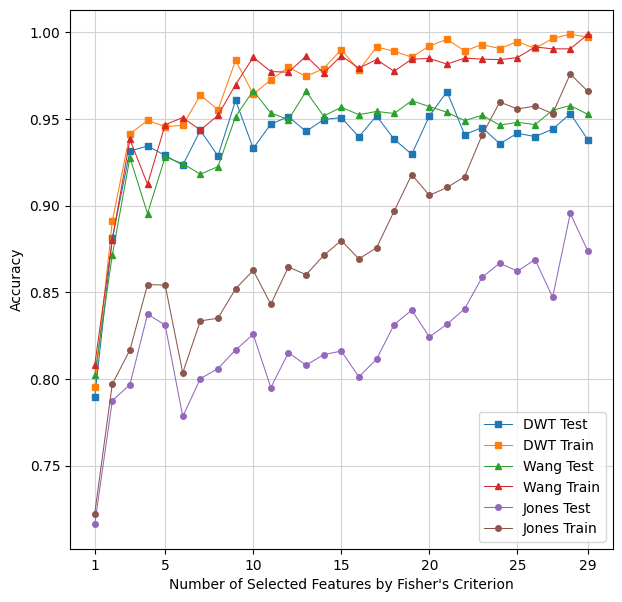

In [10]:
x = merged_logreg_default['n_features']
y = merged_logreg_default[['mean_dwt', 'mean_train_dwt', 'mean_wang', 'mean_train_wang', 'mean_jones', 'mean_train_jones']]

plt.figure(figsize=(7, 7))

import itertools
marker = itertools.cycle(('s', 's', '^', '^', 'o', 'o')) 
for i in range(0,len(y.columns)):
    plt.plot(x, y.iloc[:, i], markersize= 4, marker = next(marker), linewidth=0.75)

plt.legend(['DWT Test', 'DWT Train', 'Wang Test', 'Wang Train', 'Jones Test', 'Jones Train'], loc='lower right')
#plt.title('Logistic Regression with DWT, Wang, and Jones Methods for Ovarian 8-7-02')
plt.xlabel("Number of Selected Features by Fisher's Criterion")
plt.ylabel('Accuracy')
plt.xticks([1, 5, 10, 15, 20, 25, 29])
plt.grid(color='lightgrey')

In [20]:
lr_default_acc_dwt_topten_8 = log_reg_default(dwt_topten_8, n_iter=10000)
lr_default_acc_wang_topten_8 = log_reg_default(wang_topten_8, n_iter=10000)
lr_default_acc_jones_topten_8 = log_reg_default(jones_topten_8, n_iter=10000)

print('DWT Method Accuracy ', round(lr_default_acc_dwt_topten_8['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(lr_default_acc_wang_topten_8['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(lr_default_acc_jones_topten_8['accuracy'].mean(), 4))

DWT Method Accuracy  0.949
Wang Method Accuracy  0.9648
Jones Method Accuracy  0.7917


In [6]:
lr_default_acc_dwt_topten_4 = log_reg_default(dwt_topten_4, n_iter=10000, balanced=True)
lr_default_acc_wang_topten_4 = log_reg_default(wang_topten_4, n_iter=10000, balanced=True)
lr_default_acc_jones_topten_4 = log_reg_default(jones_topten_4, n_iter=10000, balanced=True)

print('DWT Method Accuracy ', round(lr_default_acc_dwt_topten_4['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(lr_default_acc_wang_topten_4['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(lr_default_acc_jones_topten_4['accuracy'].mean(), 4))

DWT Method Accuracy  0.8183
Wang Method Accuracy  0.7924
Jones Method Accuracy  0.7914


# Scratchpad

## Logistic Regression: forward selection

In [7]:
def log_reg_selection(df, n_iter = 100, n_features=10): 

    feature_arr = [] #empty array to store selected features
    df = df

    subset_0 = df[df['state'] == 0]
    subset_1 = df[df['state'] == 1]

    subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
    df = pd.concat([subset_0, subset_1])

    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    } 

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)
        
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test) 

        log_reg_model = LogisticRegression(max_iter=500, penalty=None) #no penalty/regularization since feature selection performed, defaults for everything else
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
        sfs = SequentialFeatureSelector(log_reg_model, direction='forward', scoring='accuracy', 
                                        n_features_to_select=n_features, cv=cv, n_jobs=-1)
    
        result = sfs.fit(x_train, y_train.values.ravel()) #fit with SequentialFeatureSelector
        #print(result.get_feature_names_out()) #print array of selected features
        x_train_sel = result.transform(x_train) #reduce training set to the selected features
        x_test_sel = result.transform(x_test) #reduce test set to the selected features

        sel_features_idx = sfs.get_support() #get boolean list of selected features
        sel_features = x.columns[sel_features_idx] #get column names of selected features
        feature_arr.append(sel_features) #store selected features in array

        result = log_reg_model.fit(x_train_sel, y_train.values.ravel()) #fit logistic regression model with filtered training set
        y_pred = result.predict(x_test_sel) #generate predictions with filtered test set
        report = classification_report(y_test, y_pred, output_dict=True) #generate classification report from test set 

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    feature_arr = np.asarray(feature_arr) #convert list to np array
    feature_arr_flat = np.ravel(feature_arr) #flatten np array

    return eval_metrics_df, feature_arr_flat

### DWT

In [8]:
acc_df_forward_dwt, feature_arr_flat_dwt = log_reg_selection(dwt, n_iter=100, n_features=10) #run forward feature selection for dwt8, 10 features

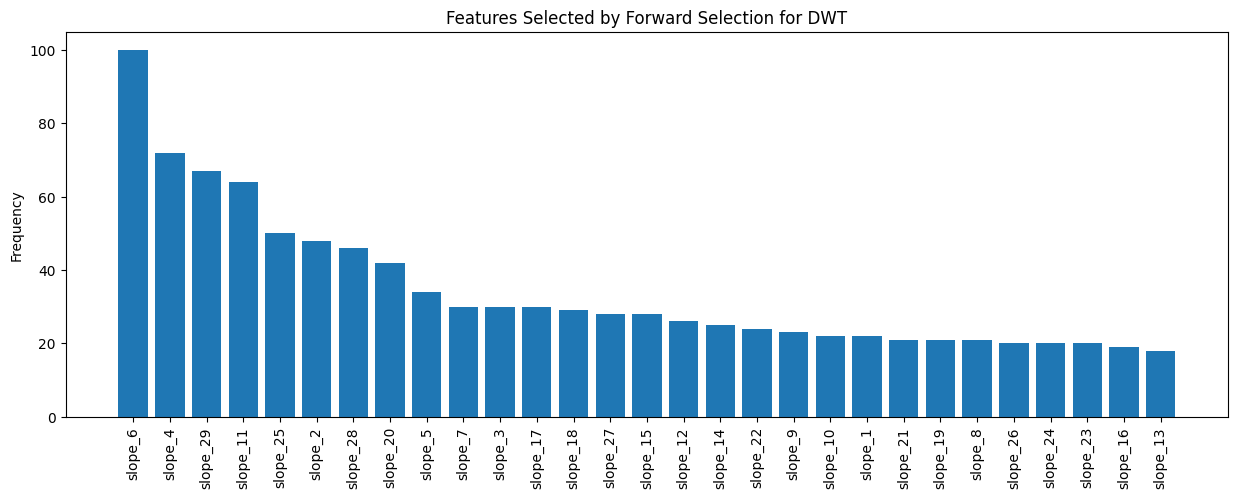

In [9]:
feature_count_arr_dwt = np.unique(feature_arr_flat_dwt, return_counts=True)
feature_count_df_dwt = pd.DataFrame(feature_count_arr_dwt).T
feature_count_df_dwt.columns = ['feature', 'frequency']
feature_count_df_dwt = feature_count_df_dwt.sort_values('frequency', ascending=False)
feature_count_top10_dwt = feature_count_df_dwt.head(10) #top 10 features by frequency

plt.figure(figsize=(15,5))
plt.bar(feature_count_df_dwt['feature'], feature_count_df_dwt['frequency'])
plt.title("Features Selected by Forward Selection for DWT")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [10]:
top10_features = feature_count_top10_dwt['feature'].tolist()
top10_features.append('state') 

dwt_forward_filtered = dwt.loc[:,top10_features] #filter dwt dataframe to only include top 10 features
dwt_forward_filtered.head()

,slope_6,slope_4,slope_29,slope_11,slope_25,slope_2,slope_28,slope_20,slope_5,slope_7,state
0,-2.853814,-2.567832,-2.390560,-2.409633,-2.868000,-2.390083,-2.616103,-2.931648,-2.714483,-2.587323,1
1,-2.664095,-2.322088,-2.344442,-2.428556,-2.815763,-2.243269,-2.701947,-3.017540,-2.544736,-2.746503,1
2,-2.848399,-2.477289,-2.603805,-2.089429,-2.872999,-2.286579,-2.744103,-3.043497,-2.450869,-2.664014,1
3,-2.738331,-2.373840,-2.401006,-1.990729,-2.847411,-2.357384,-2.614736,-3.056333,-2.467567,-2.708997,1
4,-2.718791,-2.333251,-2.421083,-1.712213,-2.842104,-2.423288,-2.682061,-3.051181,-2.608106,-2.697185,1


In [15]:
acc_df_dwt_forward_filtered = log_reg_default(dwt_forward_filtered, n_iter=500) #run random search for filtered dataframe

print(round(acc_df_dwt_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.942


### Wang

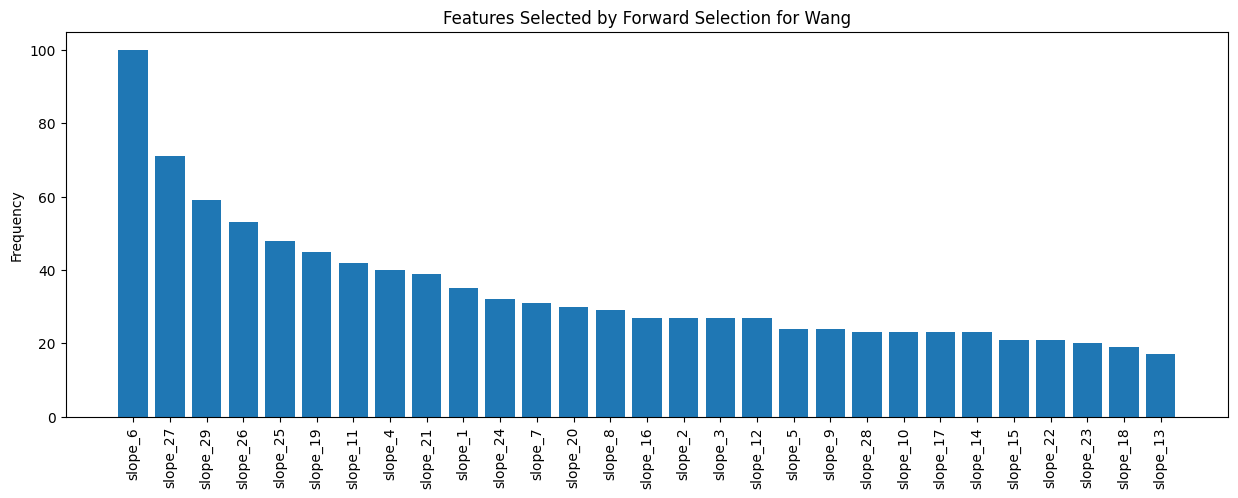

In [16]:
acc_df_forward_wang, feature_arr_flat_wang = log_reg_selection(wang, n_iter=100, n_features=10) #run forward feature selection for wang8, 10 features


feature_count_arr_wang = np.unique(feature_arr_flat_wang, return_counts=True)
feature_count_df_wang = pd.DataFrame(feature_count_arr_wang).T
feature_count_df_wang.columns = ['feature', 'frequency']
feature_count_df_wang = feature_count_df_wang.sort_values('frequency', ascending=False)
feature_count_top10_wang = feature_count_df_wang.head(10) #top 10 features by frequency


plt.figure(figsize=(15,5))
plt.bar(feature_count_df_wang['feature'], feature_count_df_wang['frequency'])
plt.title("Features Selected by Forward Selection for Wang")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [17]:
top10_features = feature_count_top10_wang['feature'].tolist()
top10_features.append('state') 

wang_forward_filtered = wang.loc[:,top10_features] #filter dwt dataframe to only include top 10 features
wang_forward_filtered.head()

acc_df_wang_forward_filtered = log_reg_default(wang_forward_filtered, n_iter=500) #run logistic regression on filtered dataframe

print(round(acc_df_wang_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.9563


### Jones

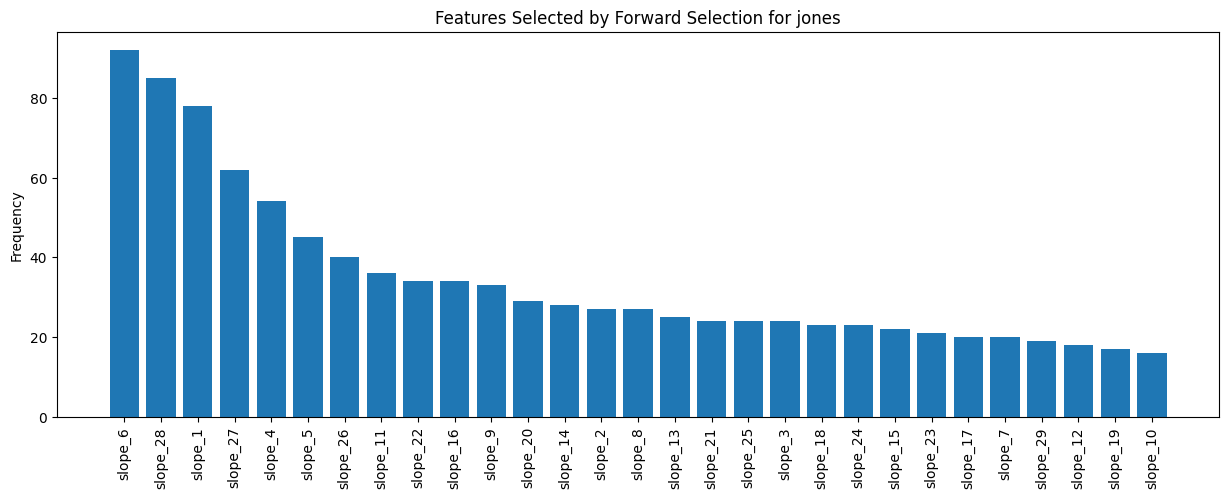

In [18]:
acc_df_forward_jones, feature_arr_flat_jones = log_reg_selection(jones, n_iter=100, n_features=10) #run forward feature selection for jones8, 10 features

feature_count_arr_jones = np.unique(feature_arr_flat_jones, return_counts=True)
feature_count_df_jones = pd.DataFrame(feature_count_arr_jones).T
feature_count_df_jones.columns = ['feature', 'frequency']
feature_count_df_jones = feature_count_df_jones.sort_values('frequency', ascending=False)
feature_count_top10_jones = feature_count_df_jones.head(10) #top 10 features by frequency

plt.figure(figsize=(15,5))
plt.bar(feature_count_df_jones['feature'], feature_count_df_jones['frequency'])
plt.title("Features Selected by Forward Selection for jones")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [19]:
top10_features = feature_count_top10_jones['feature'].tolist()
top10_features.append('state')

jones_forward_filtered = jones.loc[:,top10_features] #filter dwt dataframe to only include top 10 features
jones_forward_filtered.head()

acc_df_jones_forward_filtered = log_reg_default(jones_forward_filtered, n_iter=500) #run random search for filtered dataframe

print(round(acc_df_jones_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.9162


### Cumulative Accuracy Plot Function

In [ ]:
#calling imported function from accuracy_plots.ipynb for 8-7-02
'''
cumulative_accuracy_plot(classifier_name = 'Logistic Regression',
                            df=lr_default_acc_dwt_8, 
                            df_name='DWT')

cumulative_accuracy_plot(classifier_name = 'Logistic Regression',
                            df=lr_default_acc_wang_8, 
                            df_name='Wang')

cumulative_accuracy_plot(classifier_name = 'Logistic Regression',
                            df=lr_default_acc_jones_8, 
                            df_name='Jones')
'''

"\ncumulative_accuracy_plot(classifier_name = 'Logistic Regression',\n                            df=lr_default_acc_dwt_8, \n                            df_name='DWT')\n\ncumulative_accuracy_plot(classifier_name = 'Logistic Regression',\n                            df=lr_default_acc_wang_8, \n                            df_name='Wang')\n\ncumulative_accuracy_plot(classifier_name = 'Logistic Regression',\n                            df=lr_default_acc_jones_8, \n                            df_name='Jones')\n"